# Лабораторная работа
Решите пожалуйста следующие задачи.
1. Рассчитайте метрики TF-IDF для любых 10 песен на одном языке, которые вы
сами выберите.
Не забудьте, что нужно привести слова к начальной форме, убрать
стоп-слова.
2. Цель этого задания - использовать предварительно обученную модель BERT
для классификации тональности отзывов на фильмы.
- Скачайте датасет отзывов на фильмы. Датасет содержит текст отзыва и
бинарную метку тональности (положительный/отрицательный).
- Используйте библиотеку Hugging Face для загрузки предварительно обученной
модели BERT и токенизатора.
- Подготовьте данные: используйте токенизатор BERT для преобразования
текстовых данных в формат, который можно подать на вход модели BERT.
- Создайте классификатор на основе BERT: это может быть модель BERT с
одним линейным слоем для классификации на вершине.
- Обучите классификатор на данных обучения и оцените его
производительность на данных для тестирования

## Импорт библиотек

In [124]:
!pip install wordcloud # отображение на графике мешка слов
!pip install pymorphy2

In [125]:
import os # работа с папкой и файлами
import re # регулярные выражения, доп вариант к очистке

import nltk # работа с пакетами языков
from nltk import word_tokenize, ngrams # токенизация и деление на n граммы
from wordcloud import WordCloud # визуальное отображение
from nltk.corpus import stopwords # стопслова, extend
nltk.download("stopwords")
nltk.download('punkt')
import pymorphy2 # работа с русским языком
import string # работа со строкой
import pandas as pd # работа с таблицей dataframe
import matplotlib.pyplot as plt # визуальное отображение

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Задача 1. Рассчитать метрики TF-IDF для 10 песен

In [126]:
from google.colab import drive
drive.mount('/content/gdrive')
from zipfile import ZipFile
file_name = ('/content/gdrive/MyDrive/songs.zip')

with ZipFile(file_name, 'r') as zipf:
  zipf.extractall()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [127]:
COMMON_DIR = "songs"

def read_song(filename):
    #Функция чтения файла
    text = ''
    with open(f'{COMMON_DIR}/{filename}.txt', 'r', encoding='utf-8') as f:
        text = f.read()
        text = text.replace('\n', ' ')
    return text

In [128]:
texts = []

direct_list = os.listdir(COMMON_DIR) # файлы в папке
print(direct_list)

# имена песен
names = [song.replace(".txt", "") for song in direct_list]
print(names)

['piknik-u-shmana-tri-ruki.txt', 'agata-kristi-serdcebienie.txt', 'tanci-minus-polovinka.txt', 'kish-kukla-kolduna.txt', 'aria-bivni-chernih-skal.txt', 'kino-gruppa-krovi.txt', 'lapis-ogonki.txt', 'splin-skazhi.txt', 'smislovie-gallucinacii-zvezdi-3000.txt', 'kukriniksi-ne-beda.txt', 'nautilus-krilia.txt']
['piknik-u-shmana-tri-ruki', 'agata-kristi-serdcebienie', 'tanci-minus-polovinka', 'kish-kukla-kolduna', 'aria-bivni-chernih-skal', 'kino-gruppa-krovi', 'lapis-ogonki', 'splin-skazhi', 'smislovie-gallucinacii-zvezdi-3000', 'kukriniksi-ne-beda', 'nautilus-krilia']


In [129]:
songs_list = []
for song in names:
    songs_list.append(read_song(song)) #чтение данных

songs_list

['У шамана три руки И крыло из-за плеча От дыхания его Разгорается свеча И порою сам себя Сам себя не узнает А распахнута душа Надрывается, поет У шамана три руки Мир вокруг, как темный зал На ладонях золотых Нарисованы глаза Видит розовый рассвет Прежде солнца самого А казалось, будто спит И не знает ничего У шамана три руки Сад в рубиновых лучах От дыхания его разгорается, разгорается...',
 'Да будет тень, да будет свет Я проживу эоны лет Пока пойму, что у меня Есть только ты и только я. Что мир лишь сон, где мы не спим Познаем страх и вместе с ним Шагнем в огонь, напьёмся слёз И повернём земную ось. Мы как вода... Как вода в море, кровь в жилах Боль в сердце, нож в спину Двое как крылья, сон в руку Миг счастья, жизнь в муках. Не хочу другой судьбы Где есть не я, где есть не ты Благодарю сейчас и здесь За всё, что нет и всё, что есть. Мы как вода в море, кровь в жилах Боль в сердце, нож в спину Двое как крылья, сон в руку Миг счастья, жизнь в муках. В море... В жилах... В сердце... К

In [130]:
stopwords_list= stopwords.words("russian") #стоп-слова русского языка
len(stopwords_list)

151

In [131]:
extra_stop = ['его', 'сам', 'мне', 'мой', 'тех', 'него', 'нем', 'твой', 'это', 'твоей', 'свои', 'тобой', 'всё', 'оно']
stopwords_list.extend(extra_stop)

In [132]:
def clean_string(text):
    #Функция очищения строк
    string.punctuation += '—'

    text = re.split(' |:|\.|\(|\)|,|"|;|/|\n|\t|-|\?|\[|\]|!', text)
    text = ' '.join([word for word in text if word not in string.punctuation])
    text = text.lower()
    text = ' '.join([word for word in text.split() if word not in stopwords_list])
    return text

In [133]:
songs_list_сlean = [clean_string(song) for song in songs_list]
songs_list_сlean

['шамана руки крыло плеча дыхания разгорается свеча порою узнает распахнута душа надрывается поет шамана руки мир вокруг темный зал ладонях золотых нарисованы глаза видит розовый рассвет прежде солнца самого казалось спит знает шамана руки сад рубиновых лучах дыхания разгорается разгорается',
 'тень свет проживу эоны лет пока пойму мир лишь сон спим познаем страх вместе шагнем огонь напьёмся слёз повернём земную ось вода вода море кровь жилах боль сердце нож спину двое крылья сон руку миг счастья жизнь муках хочу судьбы благодарю вода море кровь жилах боль сердце нож спину двое крылья сон руку миг счастья жизнь муках море жилах сердце вода кровь боль жизнь',
 'ночного огня огромной луной темный лес укрывал зеленой листвой целовал ночного огня тебе подарил половинку свет далекой звезды песни птиц утра смотрела глаза мои шептала слова верила любила оставил половинку забыто прошло махала вслед бирюзовым платком целовал ночного огня оставила половинку',
 'тёмный мрачный коридор цыпочках во

In [134]:
morph = pymorphy2.MorphAnalyzer()

def normilize_word(text):
    # привести слова к начальной форме
    words = text.split() # по пробелу разделить
    result_list = []
    for word in words:
        # print(morph.parse(word))
        normal_form = morph.parse(word)[0].normal_form
        result_list.append(normal_form)
        print(normal_form)
    return " ".join(result_list)

In [135]:
songs_list_norm = [normilize_word(song) for song in songs_list_сlean]
songs_list_norm

шаман
рука
крыло
плечо
дыхание
разгораться
свеча
порою
узнать
распахнуть
душа
надрываться
петь
шаман
рука
мир
вокруг
тёмный
зал
ладонь
золотой
нарисовать
глаз
видеть
розовый
рассвет
прежде
солнце
сам
казаться
спать
знать
шаман
рука
сад
рубиновый
луч
дыхание
разгораться
разгораться
тень
свет
прожить
эон
год
пока
понять
мир
лишь
сон
спать
познать
страх
вместе
шагнуть
огонь
напиться
слеза
повернуть
земной
ось
вода
вода
море
кровь
жила
боль
сердце
нож
спина
двое
крыло
сон
рука
миг
счастие
жизнь
мука
хотеть
судьба
благодарить
вода
море
кровь
жила
боль
сердце
нож
спина
двое
крыло
сон
рука
миг
счастие
жизнь
мука
море
жила
сердце
вода
кровь
боль
жизнь
ночной
огонь
огромный
луна
тёмный
лес
укрывать
зелёный
листва
целовать
ночной
огонь
ты
подарить
половинка
свет
далёкий
звезда
песня
птица
утро
смотреть
глаз
мой
шептать
слово
верить
любить
оставить
половинка
забытый
пройти
махать
вслед
бирюзовый
платок
целовать
ночной
огонь
оставить
половинка
тёмный
мрачный
коридор
цыпочки
вор
пробираться
дышать


['шаман рука крыло плечо дыхание разгораться свеча порою узнать распахнуть душа надрываться петь шаман рука мир вокруг тёмный зал ладонь золотой нарисовать глаз видеть розовый рассвет прежде солнце сам казаться спать знать шаман рука сад рубиновый луч дыхание разгораться разгораться',
 'тень свет прожить эон год пока понять мир лишь сон спать познать страх вместе шагнуть огонь напиться слеза повернуть земной ось вода вода море кровь жила боль сердце нож спина двое крыло сон рука миг счастие жизнь мука хотеть судьба благодарить вода море кровь жила боль сердце нож спина двое крыло сон рука миг счастие жизнь мука море жила сердце вода кровь боль жизнь',
 'ночной огонь огромный луна тёмный лес укрывать зелёный листва целовать ночной огонь ты подарить половинка свет далёкий звезда песня птица утро смотреть глаз мой шептать слово верить любить оставить половинка забытый пройти махать вслед бирюзовый платок целовать ночной огонь оставить половинка',
 'тёмный мрачный коридор цыпочки вор проби

In [136]:
df = []
df = pd.DataFrame({'name': names, 'song_text': songs_list_norm})
df

,name,song_text
0,piknik-u-shmana-tri-ruki,шаман рука крыло плечо дыхание разгораться све...
1,agata-kristi-serdcebienie,тень свет прожить эон год пока понять мир лишь...
2,tanci-minus-polovinka,ночной огонь огромный луна тёмный лес укрывать...
3,kish-kukla-kolduna,тёмный мрачный коридор цыпочки вор пробираться...
4,aria-bivni-chernih-skal,бивень чёрный скала пещера тупой оскал человек...
5,kino-gruppa-krovi,тёплый место улица ждать отпечаток наш нога зв...
6,lapis-ogonki,глупый снежинка таять гирлянда розовый свинка ...
7,splin-skazhi,нева великолепный вид идти голова идти гранит ...
8,smislovie-gallucinacii-zvezdi-3000,звезда небо падать бисер сидеть окно звезда жд...
9,kukriniksi-ne-beda,погоня уйти зазря найти дом дом уйти кругом зн...


In [137]:
# Создание объекта TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

# Применение TF-IDF к текстовым данным
tfidf_matrix = tfidf_vectorizer.fit_transform(songs_list_norm)

# Получение списка ключевых слов и их значения TF-IDF для первого документа
feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_scores = tfidf_matrix.toarray()[0]

# Сортировка слов по значениям TF-IDF
sorted_keywords = [word for _, word in sorted(zip(tfidf_scores, feature_names), reverse=True)]

print("Ключевые слова:", sorted_keywords)

Ключевые слова: ['шаман', 'разгораться', 'рука', 'дыхание', 'узнать', 'свеча', 'сам', 'сад', 'рубиновый', 'рассвет', 'распахнуть', 'прежде', 'порою', 'плечо', 'петь', 'надрываться', 'луч', 'ладонь', 'казаться', 'золотой', 'зал', 'душа', 'солнце', 'розовый', 'нарисовать', 'мир', 'вокруг', 'спать', 'крыло', 'знать', 'глаз', 'видеть', 'тёмный', 'ёлка', 'юпитер', 'эхо', 'этот', 'этаж', 'эон', 'шутка', 'шрам', 'шептать', 'шагнуть', 'шагать', 'чёрный', 'читать', 'черта', 'человек', 'чей', 'час', 'цыпочки', 'цепляться', 'цена', 'цель', 'целый', 'целовать', 'хотеться', 'хотеть', 'хоровод', 'холодный', 'фокус', 'утянуть', 'утро', 'утонуть', 'устать', 'управлять', 'упасть', 'унести', 'улица', 'укрывать', 'уйти', 'удача', 'увидеть', 'тёплый', 'ты', 'тупой', 'туман', 'туда', 'треснуть', 'трава', 'тесно', 'тень', 'темнота', 'твой', 'таять', 'такой', 'тайна', 'тайком', 'считать', 'счастие', 'судьба', 'страшный', 'страшно', 'страх', 'стоя', 'сто', 'стена', 'стезя', 'ставить', 'срывать', 'среди', 'спу

In [138]:
feature_names

array(['бархат', 'беда', 'безумный', 'бел', 'бессонница', 'бивень',
       'бирюзовый', 'бисер', 'битый', 'благодарить', 'близиться', 'бог',
       'бой', 'боль', 'бояться', 'бросать', 'бросить', 'буква', 'быстрый',
       'вдвоём', 'великолепный', 'верить', 'вернуться', 'верх', 'верхний',
       'весь', 'вечерний', 'взглянуть', 'взять', 'вид', 'видать',
       'видеть', 'вместе', 'вниз', 'вовремя', 'вода', 'война', 'вокруг',
       'вор', 'ворона', 'впервые', 'время', 'вслед', 'высокий', 'гагарин',
       'гирлянда', 'гладкий', 'глаз', 'глупый', 'год', 'голова',
       'гонение', 'гора', 'гранит', 'грозд', 'грудь', 'группа',
       'грустный', 'давно', 'далёкий', 'двое', 'девочка', 'дело', 'день',
       'деньга', 'добраться', 'дождь', 'доказывать', 'должный', 'дом',
       'дотронуться', 'дрожь', 'дурачок', 'душа', 'дыхание', 'дышать',
       'её', 'жаль', 'жаркий', 'ждать', 'желать', 'жизнь', 'жила',
       'жрать', 'забытый', 'забыться', 'завтра', 'заглянуть', 'загубить',
       'з

In [139]:
tfidf_scores

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.10422883, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.11851673, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.10422883, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.13865439, 0.27730

##  Задание 2. Использовать предварительно обученную модель BERT для классификации тональности отзывов на фильмы

- Скачайте датасет отзывов на фильмы. Датасет содержит текст отзыва и
бинарную метку тональности (положительный/отрицательный).
- Используйте библиотеку Hugging Face для загрузки предварительно обученной
модели BERT и токенизатора.
- Подготовьте данные: используйте токенизатор BERT для преобразования
текстовых данных в формат, который можно подать на вход модели BERT.
- Создайте классификатор на основе BERT: это может быть модель BERT с
одним линейным слоем для классификации на вершине.
- Обучите классификатор на данных обучения и оцените его
производительность на данных для тестирования.

In [140]:
!pip install transformers

In [141]:
import torch
import transformers as bert_trained
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

### Чтение данных

In [142]:
df = pd.read_csv('/content/gdrive/MyDrive/IMDB Dataset.csv')
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [143]:
# удалим знаки препинания и приведем к нижнему регистру
df['review'] = df['review'].apply(lambda x: re.sub(r'[^\w\s]', '', x.lower()))
df

,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production br br the filmin...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically theres a family where a little boy j...,negative
4,petter matteis love in the time of money is a ...,positive
...,...,...
49995,i thought this movie did a down right good job...,positive
49996,bad plot bad dialogue bad acting idiotic direc...,negative
49997,i am a catholic taught in parochial elementary...,negative
49998,im going to have to disagree with the previous...,negative


In [144]:
df['sentiment'] = df['sentiment'].apply(lambda x: 1 if x=='positive' else 0)
df.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,1
1,a wonderful little production br br the filmin...,1
2,i thought this was a wonderful way to spend ti...,1
3,basically theres a family where a little boy j...,0
4,petter matteis love in the time of money is a ...,1


Text(0.5, 0, 'sentiments')

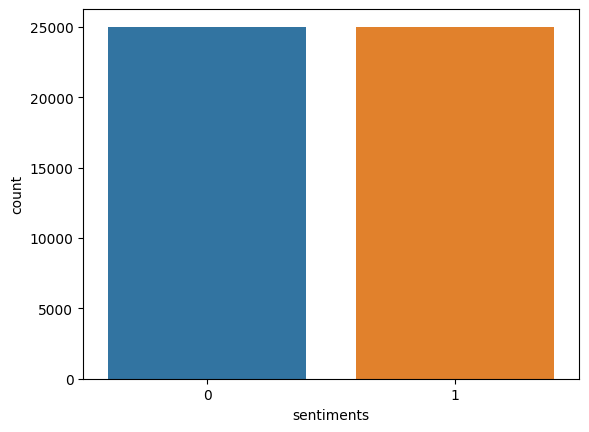

In [145]:
sns.countplot(x=df['sentiment'])
plt.xlabel('sentiments')

In [146]:
# загрузка и удаление стоп-слов
nltk.download('stopwords')
stop_words = stopwords.words('english')
stop_words.extend(['br']) # добавляет слово в словарь стоп-слов

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [205]:
short_df = df[:1000] # сократим данные, с полным датасетом модель не справляется
# Разделим данные на тренировочные и тестовые
from sklearn.model_selection import train_test_split

x = short_df['review']
y = short_df['sentiment']
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.3, random_state=15)

In [206]:
# Определим токенизатор BERT
from transformers import BertTokenizer
import torch

BERT_HUGGING_MODEL = 'bert-base-uncased' # претренированная модель BERT

tokenizer = BertTokenizer.from_pretrained(BERT_HUGGING_MODEL, do_lower_case=True) # настройка из тренированной модели, все слова lowcase

In [207]:
def preprocessing_for_bert(data):
    """Препроцессинг на модели  BERT.
    @param    data (np.array): Текст для препроц.
    @return   input_ids (torch.Tensor): Либо id token, либо объект тензор.
    @return   attention_masks (torch.Tensor): Определяем набор токенов (объекты тензоры) для работы мехонизма внимания.
    """
    # Для выходных данных пустые списки
    input_ids = []
    attention_masks = []

    # Цикл по данным
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            sent,
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,             # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length, заполнение даннх
            return_attention_mask=True      # Return attention mask
            )

        # Добавление обработанных (закодированных данных) в списки id, masks
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Преобразуем в тензоры
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)
    # print(pd.DataFrame({'idx': input_ids, 'attention': attention_masks}))

    return input_ids, attention_masks

In [208]:
x_train

366    this series made for televisión española tve i...
302    witty funny intelligent awesome i was flipping...
305    i thought this movie was stunning with complet...
684    the perfect murder is foiled when a wifeplayed...
348    most of the comments on this movie are positiv...
                             ...                        
887    a number of contributors have mentioned the ag...
645    look this is a low budget horror film that suf...
908    sometimes its hard to be a piratebut by golly ...
757    steven what have you done you have hit an all ...
456    oh my goodness i would have never thought it w...
Name: review, Length: 700, dtype: object

In [209]:
x_test

825    i found this to be a surprisingly lighthanded ...
374    a compelling thriller 10 december 2005 authorl...
488    a fey story of a martian attempt to colonize e...
608    i have recently seen this production on dvd it...
42     of all the films i have seen this one the rage...
                             ...                        
84     we brought this film as a joke for a friend an...
343    perhaps the most gripping and intelligent of c...
224    we usually think of the british as the experts...
502    it is surprising that a production like this g...
535    this film is really vile it plays on the urban...
Name: review, Length: 300, dtype: object

In [210]:
# Возьмем длину для Берта - 128
MAX_LEN = 128

train_inputs, train_masks = preprocessing_for_bert(x_train)
test_inputs, test_masks = preprocessing_for_bert(x_test)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [211]:
train_masks

tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]])

In [212]:
train_inputs

tensor([[  101,  2023,  2186,  ...,  2000,  2022,   102],
        [  101, 25591,  6057,  ..., 15937,  7113,   102],
        [  101,  1045,  2245,  ...,     0,     0,     0],
        ...,
        [  101,  2823,  2049,  ...,  2053,  3653,   102],
        [  101,  7112,  2054,  ...,  3087,  4406,   102],
        [  101,  2821,  2026,  ...,  3105,  2007,   102]])

In [213]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# преобразуем объект Series в массив

if isinstance(y_train, pd.Series):
    y_train=y_train.to_numpy() # преобразуем объект Series в массив

if isinstance(y_test, pd.Series):
    y_test=y_test.to_numpy() # преобразуем объект Series в массив

train_labels = torch.LongTensor(y_train) # делаем из numpy array LongTensor
test_labels = torch.LongTensor(y_test) # делаем из numpy array LongTensor

# batch size: 16 и 32.
batch_size = 16

# TensorDataset: входные данные (отзывы), маски для отзывов, с чем сравнивать
train_data = TensorDataset(train_inputs, train_masks, train_labels)
# RandomSampler: входные данные (отзывы)
train_sampler = RandomSampler(train_data)
# RandomSampler: входные данные (отзывы), batch_size, RandomSampler
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [214]:
import torch
import torch.nn as nn
from transformers import BertModel

# Определим классификатор BERT
class BertClassifier(nn.Module):
    def __init__(self, freeze_bert=False):
        super(BertClassifier, self).__init__()

        D_in, H, D_out = 768, 50, 2

        self.bert = BertModel.from_pretrained(BERT_HUGGING_MODEL)

        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.3), LSTM, GRU
            nn.Linear(H, D_out)
        )

        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)

        # Смотрим CLS - начало предложения (определяем отзыв)
        last_hidden_state_cls = outputs[0][:, 0, :]

        logits = self.classifier(last_hidden_state_cls)
        return logits

In [215]:
from transformers import AdamW, get_linear_schedule_with_warmup

# Инициализируем модель
EPOCH_NUM = 4

def initialize_model(epochs=EPOCH_NUM):
    # экземпляр BertClassifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Задаем устройство (GPU T4)
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # learning rate
                      eps=1e-8    # epsilon - точность функции, до какого значения считать
                      )

    # Расчет циклов для работы
    total_steps = len(train_dataloader) * epochs

    # Загрузчик, расписание (последовательность) и число циклов для обучения
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

In [216]:
import random
import time
import numpy as np

# Функция обучения
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=1):
  '''
  Воспроизводимость модели, по умолчанию seed_value=42
  '''
  random.seed(seed_value)
  np.random.seed(seed_value)
  torch.manual_seed(seed_value)
  torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, test_dataloader=None, epochs=EPOCH_NUM, evaluation=False):
    """

      Тренировка BertClassifier model

    """
    print("Начало тренировки...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Test Loss':^10} | {'Test Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Измерение времени (elapsed time of each epoch)
        t0_epoch, t0_batch = time.time(), time.time()

        # Обнулить переменные
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Перевод в режим тренировки
        model.train()

        # Для каждого batch
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Загружаем каждую batch в GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Использование нулевого градиента
            model.zero_grad()

            # Добавляем в модель id и маски
            logits = model(b_input_ids, b_attn_mask)

            # Считаем потери (Кросс Энтропия)
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Расчет градиентов функцией backward
            loss.backward()

            # Решение проблемы "взрывных градиентов"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Обновляем шаг для оптимизатора и расписания
            optimizer.step()
            scheduler.step()

            # Печатаем значения для каждых 20 batch
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Время расчета 20 batches
                time_elapsed = time.time() - t0_batch

                # Результаты
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Обнулим переменные
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Средняя функция потерь
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Оценка
        # =======================================
        if evaluation == True:
            # Считается точность
            test_loss, test_accuracy = evaluate(model, test_dataloader)

            # Общее время, затраченное на измерение
            time_elapsed = time.time() - t0_epoch

            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {test_loss:^10.6f} | {test_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")

    print("Тренировка завершена!")

In [217]:
# Определим функцию вычисления показателей качества модели (функцию потерь и точность)
def evaluate(model, test_dataloader):

    model.eval()

    test_accuracy = []
    test_loss = []

    for batch in test_dataloader:
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        loss = loss_fn(logits, b_labels)
        test_loss.append(loss.item())

        preds = torch.argmax(logits, dim=1).flatten()

        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        test_accuracy.append(accuracy)

    test_loss = np.mean(test_loss)
    test_accuracy = np.mean(test_accuracy)

    return test_loss, test_accuracy

In [219]:
# Выполним обучение модели
device = torch.device( 'cuda' if torch.cuda.is_available() else 'cpu' )

set_seed(1)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=1)
train(bert_classifier, train_dataloader, test_dataloader, epochs=1, evaluation=True)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Начало тренировки...

 Epoch  |  Batch  |  Train Loss  | Test Loss  | Test Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.670782   |     -      |     -     |  507.51  
   1    |   40    |   0.566241   |     -      |     -     |  451.90  
   1    |   43    |   0.444023   |     -      |     -     |   62.32  
----------------------------------------------------------------------
   1    |    -    |   0.607802   |  0.468679  |   79.82   |  1158.37 
----------------------------------------------------------------------


Тренировка завершена!


In [220]:
# Определим функцию предсказания положительного/отрицательного отзыва с использованием обученной модели
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    model.eval()

    all_logits = []

    for batch in test_dataloader:
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)

    # Сбор из каждого batch результатов в один объект
    all_logits = torch.cat(all_logits, dim=0)

    # Для вероятности принадлежности к классу
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

In [221]:
# Построим график ROC-кривой для наглядной оценки качества предсказания
from sklearn.metrics import accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt

%matplotlib inline

def evaluate_roc(probs, y_true):

    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')

    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')

    # ROC AUC
    plt.title('Оценка ROC AUC')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

AUC: 0.8964
Accuracy: 79.67%


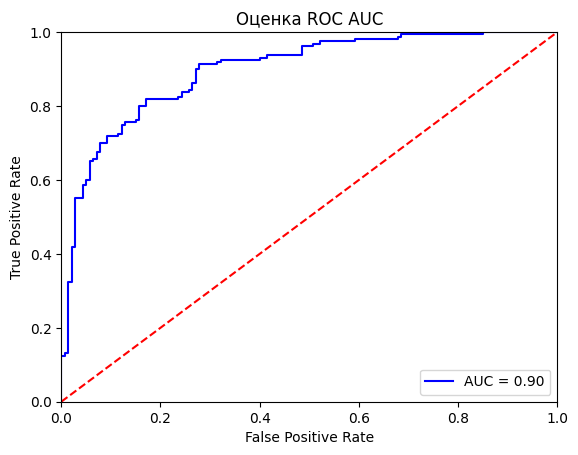

In [222]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, test_dataloader)

# Evaluate the Bert classifier
evaluate_roc(probs, y_test)